# reaction-network (Demo Notebook, v2)
### Author: Matthew McDermott
### Date: January 28, 2021

The following notebook serves as a walkthrough for the use of the *reaction-network* code, which is imported as *rxn_network*. 

In the following examples, we recreate the results/analysis originally presented in the manuscript: 

*Matthew J. McDermott, Shyam Dwaraknath, and Kristin A. Persson. “A graph-based network for predicting chemical reaction pathways in solid-state materials synthesis” (2021)*.


## Imports
The following imports are required to access the Materials Project database and construct the network.  Don't worry if you see an error regarding the cairo package for drawing the networks; this part is optional.

In [1]:
import logging
import pickle
import json
import numpy as np
import itertools
from datetime import date

from monty.json import MontyDecoder

import graph_tool.all as gt

from rxn_network.core import ReactionNetwork
from rxn_network.entries import CustomEntry, GibbsComputedStructureEntry
from rxn_network.helpers import find_interdependent_rxns
from rxn_network.reaction import Reaction, ComputedReaction

from pymatgen import MPRester, Structure, Composition
from pymatgen.analysis.phase_diagram import PhaseDiagram

Note: this code uses Dask to parallelize the building of the reaction network graph. The client is initialized below, and the Dask web GUI can be accessed via a local HTTP server (see Dask documentation for further details).

In [2]:
from dask.distributed import Client
client = Client()
logging.info("Logging initialized")
print("Client initialized...")

/Users/mcdermott/miniconda3/envs/gt/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55872 instead
  warnings.warn(


Client initialized...


## Main script
The following function's code can be run as a standalone script to generate the reaction network and perform pathfinding. In the first example that follows, we will break down each of these steps so it is clear what each section of the script is doing. In the following sections, we will only povide the input parameters and refer you to running the main script yourself.

In [3]:
def reaction_network_analysis(entries, precursors, targets, temp, include_metastable, k, chempots, max_num_combos, interpolate_comps=[]):
    rn = ReactionNetwork(entries, temp=temp, interpolate_comps=interpolate_comps, 
                         include_metastable=include_metastable)

    precursors_comps = [Composition(s) for s in precursors]
    targets_comps = [Composition(t) for t in targets]

    precursor_entries = []
    target_entries = []

    for entry in rn._filtered_entries:
        if entry.composition.reduced_composition in precursors_comps:
            precursor_entries.append(entry)
        elif entry.composition.reduced_composition in targets_comps:
            target_entries.append(entry)

    rn.generate_rxn_network(precursor_entries,target_entries)
    paths = rn.find_all_rxn_pathways(k=k, precursors=precursor_entries, consider_crossover_rxns=True, 
                                         max_num_combos=max_num_combos, filter_interdependent=False,
                                        chempots=chempots)
    return rn, paths

# Example 1: YMnO$_3$ assisted metathesis

## Building the phase diagram entries

First, we acquire Materials Project entries for the C-Cl-Li-Mn-O-Y chemical system via the MPRester API; please see materialsproject.org to create an account and get an API key.

Note: *You may also use your own thermodynamic database entries, but they must be initialized as ComputedStructureEntry objects in pymatgen*.

In [4]:
chemsys = "C-Cl-Li-Mn-O-Y"
with MPRester() as mpr:  # requires API key from Materials Project
    all_entries = mpr.get_entries_in_chemsys(chemsys, inc_structure="final") 

/Users/mcdermott/PycharmProjects/pymatgen/pymatgen/ext/matproj.py:581: FutureWarning: __init__ is deprecated
MaterialsProjectCompatibility will be updated with new correction classes as well as new values of corrections and uncertainties in 2020
  entries = MaterialsProjectCompatibility().process_entries(entries)


Let's first see how many of these entries are stable at T = 0 K by constructing a compositional phase diagram:

In [5]:
pd_mp = PhaseDiagram(all_entries)
print(pd_mp)

Li-Y-Mn-C-Cl-O phase diagram
53 stable phases: 
MnO2, Mn23C6, LiO8, Mn, Y4C7, Li2O2, Li11Mn13O32, Cl2O7, YMn2O5, YCCl, LiMn2O4, LiClO4, Cl2, YClO, Y2Mn2O7, Mn2O3, Y2Cl3, Li2O, ClO2, YCl3, Y(ClO4)3, ClO3, C, Li6MnO4, Mn7C3, Y10Mn13C18, CO2, Li9Mn14O32, Li9Mn20O40, MnCO3, MnCl2, Li4Mn5O12, LiC12, Mn8Cl3O10, Li2CO3, Li2MnO3, LiCl, Y3C4, CCl4, YMnO3, LiMnO2, Mn3O4, Y, YMn12, Li, MnO, LiYO2, Y2O3, Y4C5, O2, Y2C, Cl2O, LiMn(CO3)2


When we initialize the network in the next section, it will attempt to estimate the finite temperature phase diagram via a Gibbs estimation model, such as the SISSO model from Bartel et al. Let's see what that does to the phase diagram at T = 900 K:

In [6]:
gibbs_entries = GibbsComputedStructureEntry.from_pd(pd_mp, temp=900)
pd_gibbs = PhaseDiagram(gibbs_entries)
print(pd_gibbs)

Li-Y-Mn-C-Cl-O phase diagram
38 stable phases: 
O2, Li2MnCO4, MnO2, LiMn2O4, CCl2O, MnO, Li2CO3, Li4Mn5O12, Mn, Li2O, Mn2O3, Y4C5, Y10Mn13C18, Y2Mn2O7, YMnO3, CO2, YMn2O5, Li, Mn3O4, YClO, MnCO3, YMn12, Y2C, YCCl, LiMnO2, CCl3, C, Y2O3, MnCl2, Cl2, Y4C7, Li2Mn(CO3)2, YCl3, Mn8Cl3O10, Y, LiC12, LiCl, Li2MnO3


It appears that many structures are destabilized at high temperature according to the Gibbs SISSO descriptor. This will affect how we filter entries to include in the network.

## Creating the reaction network

To create the reaction network, we must first initialize a ReactionNetwork object with a list of ComputedStructureEntry objects (at T = 0 K). This performs necessary preprocessing steps on the list of entries, such as converting them to *GibbsComputedStructureEntry* objects and filtering for thermodynamic stability. Please see the code documentation for more description on the input parameters. In the example below, we will be using a thermodynamic stability cutoff of +30 meV/atom above hull.

In [7]:
rn = ReactionNetwork(all_entries, n=2, temp=900, include_metastable=0.030) # include entries <= 30 meV/atom above hull

INFO:ReactionNetwork:Initializing network with 75 entries: 
O2, LiMn3O6, Li2CO3, Li2O, Li7Mn10O24, Y2Cl3, Li4Mn13O24, Li4Mn3O7, Li7Mn11O24, Y2Mn2O7, YMn2O5, Mn3O4, Li4Mn3O8, YClO, Y15C19, Li3Mn2O5, CCl3, Li6MnO4, Y2O3, Li2Mn(CO3)2, Y4C7, Li2MnO3, Li7Mn16O32, MnO, Li4Mn5O12, Mn5C2, Y10Mn13C18, Li, YMn12, Li13Mn17O40, LiCl, Y3C4, MnCl2, Li5Mn3O8, YCl3, Mn8Cl3O10, Li9Mn20O40, Mn7C3, Li2MnCO4, Li2Mn3O7, Li5Mn6O12, Mn, Y4C5, YMnO3, MnCO3, Y2C, YCCl, C, Li13Mn21O48, Li95Mn16O64, Li5Mn12O24, ClO, Li2MnCO5, Li9Mn21O40, Li6Mn9O20, Li9Mn14O32, MnO2, LiMn2O4, LiYO2, CCl2O, Li3MnO3, Mn2O3, CO2, Li3Mn4O8, Li8Mn9O18, Mn5O8, Li11Mn13O32, LiMnO2, LiMnCO4, Li9Mn7O16, Li7Mn5O12, Cl2, Y2MnC4, Y, LiC12


To actually create the reaction network graph, we must specify both a list of precursor entries and list of target entries. Either (or both) of these can also be empty; if so, the network will treat these precursor/target nodes as "dummy" nodes, meaning that they will link into/out of every node in the network.

The assisted metathesis reaction reported by Todd & Neilson (2019) we would like to study is the following:

$$ Mn_2O_3 + 2 YCl_3 + 3Li_2CO_3 -> 2YMnO_3 + 6LiCl + 3CO_2 $$

We first identify the compositions of this reaction and verify that it is correct by having it automatically balanced:

In [8]:
precursors = ["Mn2O3", "YCl3","Li2CO3"]
targets = ["YMnO3","CO2","LiCl"]

precursors = [Composition(s) for s in precursors]
targets = [Composition(t) for t in targets]

net_rxn = Reaction(precursors,targets)
print(f"Net RXN: {net_rxn}")

Net RXN: 0.5 Mn2O3 + YCl3 + 1.5 Li2CO3 -> YMnO3 + 1.5 CO2 + 3 LiCl


We then need to select which entries correspond to the precursors and targets. If we only know the compositions we want, we need to iterate through all of the entries to find them:

In [9]:
precursor_entries = []
target_entries = []

for entry in rn._filtered_entries:
    if entry.composition.reduced_composition in precursors:
        precursor_entries.append(entry)
    elif entry.composition.reduced_composition in targets:
        target_entries.append(entry)

Finally, we generate the reaction network using the "softplus" cost function. 

This process iterates through all possible chemical reactions and creates weighted edges using the designated cost function. 

**Note**: this particular graph will likely take 1-2 minutes to generate, depending on your CPU specs.

In [8]:
rn.generate_rxn_network(precursor_entries,target_entries,"softplus")

INFO:ReactionNetwork:Generating reactions by chemical subsystem...
100%|██████████| 63/63 [01:20<00:00,  1.28s/it]
INFO:ReactionNetwork:Created graph with 2654 nodes and 20573 edges.


## Finding shortest pathways

Right away, we can look for shortest paths on the graph to a specific target. For example, we can look at the shortest paths from the precursors to YMnO$_3$ alone.

In [9]:
ymno3_entry = [t for t in target_entries if t.composition.reduced_formula == "YMnO3"][0]
rn.set_target(ymno3_entry)

paths = rn.find_k_shortest_paths(10)

2 YCl3 + 9 Mn2O3 -> Y2Mn2O7 + 2 Mn8Cl3O10 (dG = -0.015 eV/atom) 
0.5 Y2Mn2O7 + 0.5 Mn2O3 -> YMnO3 + MnO2 (dG = 0.026 eV/atom) 
Total Cost: 0.533 

1.5 Li2CO3 + 0.5 Mn2O3 -> Li3MnO3 + 1.5 CO2 (dG = 0.193 eV/atom) 
YCl3 + Li3MnO3 -> YMnO3 + 3 LiCl (dG = -0.207 eV/atom) 
Total Cost: 0.534 

YCl3 + 5 Mn2O3 -> YMn2O5 + Mn8Cl3O10 (dG = -0.025 eV/atom) 
YMn2O5 -> YMnO3 + MnO2 (dG = 0.069 eV/atom) 
Total Cost: 0.541 

2 YCl3 + 9 Mn2O3 -> Y2Mn2O7 + 2 Mn8Cl3O10 (dG = -0.015 eV/atom) 
2 Y2Mn2O7 -> O2 + 4 YMnO3 (dG = 0.07 eV/atom) 
Total Cost: 0.543 

Li2CO3 + Mn2O3 -> Li2MnO3 + MnCO3 (dG = 0.053 eV/atom) 
YCl3 + MnCO3 -> YMnO3 + CCl3 (dG = 0.412 eV/atom) 
Total Cost: 0.655 

2 Li2CO3 + Mn2O3 -> Li2Mn(CO3)2 + Li2MnO3 (dG = 0.042 eV/atom) 
7.667 Mn2O3 + 8 Li2MnO3 -> Li9Mn21O40 + 2.333 Li3MnO3 (dG = 0.029 eV/atom) 
YCl3 + Li3MnO3 -> YMnO3 + 3 LiCl (dG = -0.207 eV/atom) 
Total Cost: 0.767 

YCl3 + 5 Mn2O3 -> YMn2O5 + Mn8Cl3O10 (dG = -0.025 eV/atom) 
YMn2O5 + 25 Mn2O3 -> YMn12 + 40 MnO2 (dG = 0.363 eV

While this is nice for understanding which reaction(s) form YMnO$_3$, this pathway identification contains no enformcent of conservation of mass; i.e. we know the stoichiometric coefficients of the **net** reaction, so we need to combine these shortest paths in a logical way.

Thus net reaction pathways are identified by finding the k shortest paths to each target, and then attempting to combine identified reactions to form a set that satisifies the stoichiometry of the net reaction. 

**Note:** *the k-shortest paths algorithm (Yen's algorithm) typically performs very quickly, but the postprocessing of combinations can take some time to generate and balance combinations.*

In [10]:
paths, analysis = rn.find_all_rxn_pathways(k=15, max_num_combos=4)

NET RXN: YCl3 + 1.5 Li2CO3 + 0.5 Mn2O3 -> YMnO3 + 3 LiCl + 1.5 CO2 

PATHS to CO2 

0.5 Li2CO3 + 0.5 Mn2O3 -> LiMnO2 + 0.5 CO2 (dG = 0.086 eV/atom) 
Total Cost: 0.286 

1.5 Li2CO3 + 0.5 Mn2O3 -> Li3MnO3 + 1.5 CO2 (dG = 0.193 eV/atom) 
Total Cost: 0.313 

Li2CO3 -> Li2O + CO2 (dG = 0.308 eV/atom) 
Total Cost: 0.345 

Li2CO3 + Mn2O3 -> Li2MnO3 + MnCO3 (dG = 0.053 eV/atom) 
Mn2O3 + MnCO3 -> Mn3O4 + CO2 (dG = 0.022 eV/atom) 
Total Cost: 0.548 

Li2CO3 + Mn2O3 -> Li2MnO3 + MnCO3 (dG = 0.053 eV/atom) 
3.5 Li2MnO3 + 1.5 MnCO3 -> Li7Mn5O12 + 1.5 CO2 (dG = 0.03 eV/atom) 
Total Cost: 0.55 

Li2CO3 + Mn2O3 -> Li2MnO3 + MnCO3 (dG = 0.053 eV/atom) 
0.5 Li2MnO3 + 0.5 MnCO3 -> LiMnO2 + 0.5 CO2 (dG = 0.033 eV/atom) 
Total Cost: 0.55 

2 Mn2O3 -> MnO2 + Mn3O4 (dG = 0.015 eV/atom) 
MnO2 + Li2CO3 -> Li2MnO3 + CO2 (dG = 0.072 eV/atom) 
Total Cost: 0.551 

Li2CO3 -> Li2O + CO2 (dG = 0.308 eV/atom) 
Li2O + 2 CO2 -> Li2CO3 + CO2 (dG = -0.205 eV/atom) 
Total Cost: 0.566 

Li2CO3 + Mn2O3 -> Li2MnO3 + MnCO3 (dG

  1%|▏         | 1431/112791 [00:00<00:07, 14272.31it/s]

Crossover Reactions 

{YClO + LiMnO2 -> YMnO3 + LiCl (dG = -0.054 eV/atom) 
Total Cost: 0.253} 



100%|██████████| 112791/112791 [00:19<00:00, 5843.22it/s] 
/Users/mcdermott/PycharmProjects/reaction-network/rxn_network/core.py:903: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  comp_pseudo_inverse[i] = np.linalg.pinv(comp_matrices[i]).T


Let's check out the results. We should see 2 balanced pathways stored in **paths** list object.

In [11]:
for num, path in enumerate(paths):
    print(f"Path {num+1}:","\n")
    print(path)
    print("\n")

Path 1: 

1.5 Li2CO3 + 0.5 Mn2O3 -> Li3MnO3 + 1.5 CO2 (dG = 0.193 eV/atom) 
YCl3 + Li3MnO3 -> YMnO3 + 3 LiCl (dG = -0.207 eV/atom) 

Average Cost: 0.267 
Total Cost: 0.534


Path 2: 

0.5 Li2CO3 + 0.5 Mn2O3 -> LiMnO2 + 0.5 CO2 (dG = 0.086 eV/atom) 
Li2CO3 -> Li2O + CO2 (dG = 0.308 eV/atom) 
YCl3 + Li2O -> YClO + 2 LiCl (dG = -0.286 eV/atom) 
YClO + LiMnO2 -> YMnO3 + LiCl (dG = -0.054 eV/atom) 

Average Cost: 0.272 
Total Cost: 1.089




The "analysis" object also contains some helpful methods for analyzing suggested pathways, such as plotting of the frequency of intermediates which occur:

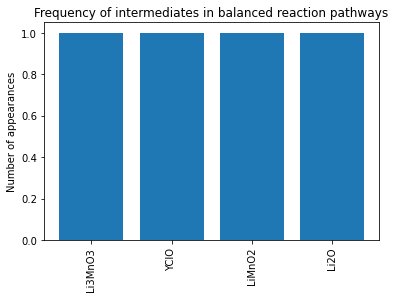

In [12]:
analysis.plot_intermediate_freq();

## Plotting the network

There are many, many methods for plotting large graphs. One of the more useful approaches is to use an interactive interface such as the one created by Graphistry. There software was also used to generate the figure of the graph in the paper.

If you wish to use Graphistry, you may sign up for an account through Graphistry Hub and use their Python API for plotting in this Jupyter Notebook. The code will probably look something like this:

    import graphistry
    import pyintergraph
    import networkx as nx

    nx_graph = pyintergraph.gt2nx(rn.g)

    mapping = {}
    for node in nx_graph.nodes(data=True):
        mapping[node[0]] = node[1]["entries"]

    nx.relabel_nodes(nx_graph, mapping, copy=False)
    
    graphistry.register(key='##### PUT YOUR API KEY HERE #####')
    graphistry.bind(source='src', destination='dst', node='nodeid', point_color='type',point_size='path').plot(nx_graph)
    

Another option is to use the built-in drawing in graph-tool, atlhough it is often more difficult to get insightful results. For example, this might look like the following, where we generate and then draw a filtered graph where zero-weight edges have been removed. This essentially just shows the "sub-networks" of chemical reactions broken down by smaller systems within the bigger chemical system. These sub-networks are connceted to each other via the zero-weight edges.

In [13]:
rn.g.ep["zero_cost"] = rn.g.new_edge_property("bool")
for s,t,weight in rn.g.iter_edges(eprops=[rn.g.ep["weight"]]):
    rn.g.ep["zero_cost"][rn.g.edge(s,t)] = (weight!=0)
    
filtered_graph = gt.GraphView(rn.g, efilt=rn.g.ep.zero_cost)

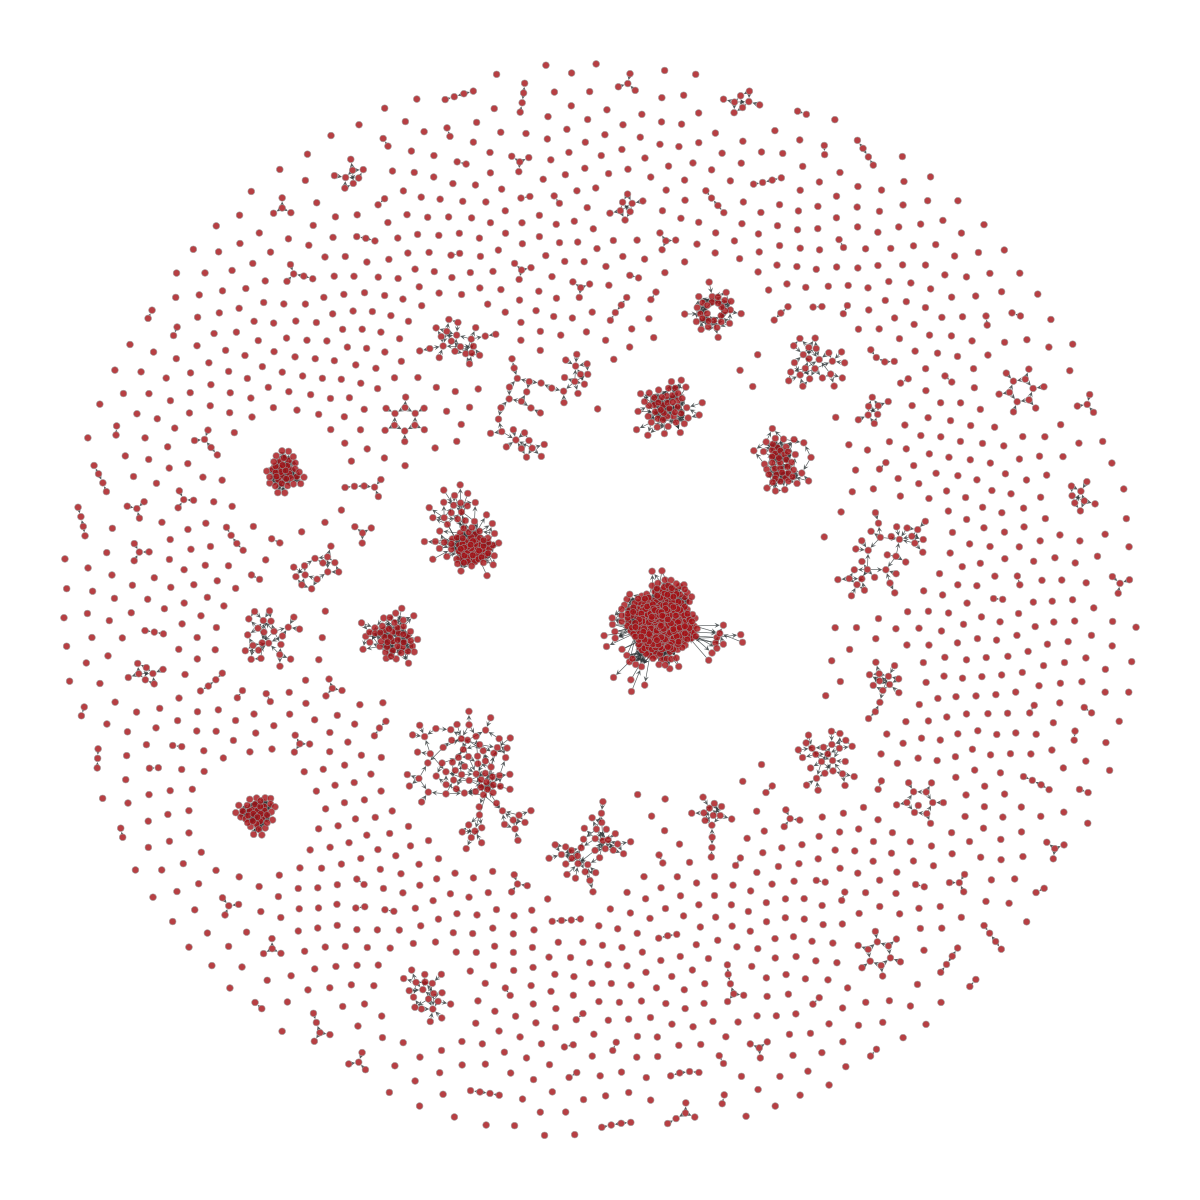

In [14]:
gt.graph_draw(filtered_graph);

There are many more insightful plots (e.g. histograms) you can make simply by using the built-in property maps of the graph-tool object. For example, you can plot the relative counts of the different sub-chemical systems represented in the graph (requires seaborn):

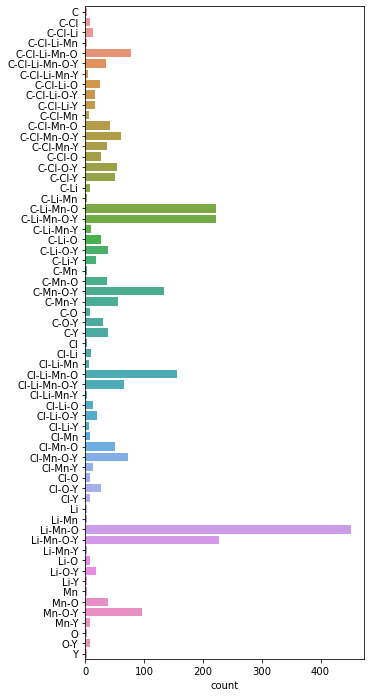

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(5,12))
sns.countplot(y=sorted(list(rn.g.vp["chemsys"])),orient="v");

# Example 2: Y$_2$Mn$_2$O$_7$ assisted metathesis

# Example 3: Fe$_2$SiS$_4$ synthesis from iron silicide precursors

# Example 4: YBCO synthesis from barium peroxide